In [21]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from scipy.sparse import vstack

In [22]:
df = pd.read_csv("./dataset_labeled_250.csv", delimiter=";")
df

,Comment,Label
0,apa yg jadi jadi maaf apa yg sdh sy komentar k...,positif
1,gw sedikit tarik sama bahas u23 anggap sukses ...,netral
2,spill bobrok pssi,negatif
3,inti smua salah sty gara2 harap masuk pildun w...,negatif
4,pelatih2 asal belanda banyak pelatih2 asal neg...,negatif
...,...,...
245,nonton menit atas banyak dapet insight baru be...,positif
246,main bola pakek tatik sesuai mampu tim tim law...,positif
247,performa beckham betul udah lihat pas lawan ch...,positif
248,opini masalah sty in kluivert out sebenernya e...,positif


## Perbandingan Jumlah Data Per Label

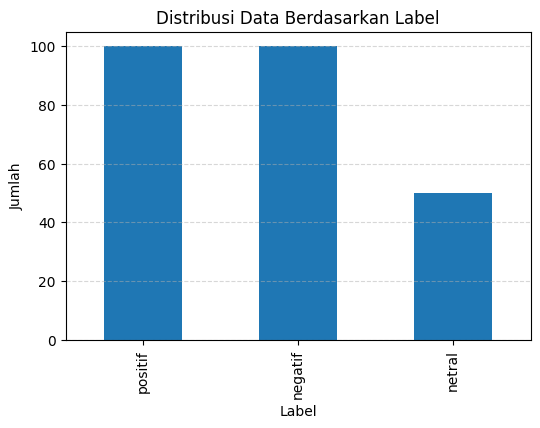

In [23]:
import matplotlib.pyplot as plt

data_per_label = df["Label"].value_counts()

plt.figure(figsize=(6,4))
data_per_label.plot(kind='bar')

plt.title("Distribusi Data Berdasarkan Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [24]:
label_positif = df[df["Label"] == "positif"].head(5)
label_negatif = df[df["Label"] == "negatif"].head(5)
label_netral  = df[df["Label"] == "netral"].head(5)

combined  = pd.concat([
    label_positif.assign(Kategori="Positif"),
    label_negatif.assign(Kategori="Negatif"),
    label_netral.assign(Kategori="Netral")
], ignore_index=True)

combined 


,Comment,Label,Kategori
0,apa yg jadi jadi maaf apa yg sdh sy komentar k...,positif,Positif
1,nya ngeblame netizen kalah dikit pecat gak min...,positif,Positif
2,klo bicara budaya bangsa arti sdh on the track...,positif,Positif
3,ferry irwandi quot jelas filosofi teory justin...,positif,Positif
4,ikut cara azrul ananda bikin dbl basket awal m...,positif,Positif
5,spill bobrok pssi,negatif,Negatif
6,inti smua salah sty gara2 harap masuk pildun w...,negatif,Negatif
7,pelatih2 asal belanda banyak pelatih2 asal neg...,negatif,Negatif
8,lu erti formasi g ngerti komposisi main bodoh ...,negatif,Negatif
9,pdhl bacot sendiri bilang even sty lolosin ind...,negatif,Negatif


## Data Unlabeled

In [25]:
no_labelling_data = pd.read_csv("./dataset_unlabeled_750.csv", delimiter=";")
no_labelling_data.columns = no_labelling_data.columns.str.strip()
if "Comment" not in no_labelling_data.columns:
    col0 = no_labelling_data.columns[0]
    if ";" in no_labelling_data.iloc[0, 0]:
        no_labelling_data = pd.read_csv("./dataset_unlabeled_750.csv", header=None, names=["Comment", "Label"], sep=";")
    else:
        raise ValueError("Kolom 'Comment' tidak ditemukan di dataset_unlabeled_750.csv")

## Validasi Data Train


In [26]:
no_labelling_data["Comment"] = no_labelling_data["Comment"].astype(str)
no_labelling_data = no_labelling_data.dropna(subset=["Comment"])

X_labeled_text = df["Comment"].reset_index(drop=True)
y_labeled = df["Label"].reset_index(drop=True)

X_unlabeled_text = no_labelling_data["Comment"].reset_index(drop=True)

X_labeled_text, X_val_text, y_labeled, y_val = train_test_split(
    X_labeled_text, y_labeled, test_size=0.2, stratify=y_labeled, random_state=42
)

## TF-IDF Vectorization

In [27]:
vectorizer = TfidfVectorizer()
all_texts_for_vocab = pd.concat([X_labeled_text, X_unlabeled_text, X_val_text], ignore_index=True)
vectorizer.fit(all_texts_for_vocab)

X_labeled = vectorizer.transform(X_labeled_text)
X_unlabeled = vectorizer.transform(X_unlabeled_text)
X_val = vectorizer.transform(X_val_text)

## Fungsi Self Training

In [28]:
def pseudo_labeling(X_labeled, y_labeled, X_unlabeled, model, threshold=0.95, max_iters=5):
    if isinstance(y_labeled, pd.Series):
        y_labeled = y_labeled.values
    for iteration in range(max_iters):
        print(f"\nIteration {iteration + 1}")
        model.fit(X_labeled, y_labeled)

        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples.")
            break

        probs = model.predict_proba(X_unlabeled)  
        confidences = probs.max(axis=1)
        preds_idx = probs.argmax(axis=1)
        preds_labels = model.classes_[preds_idx]

        mask = confidences >= threshold
        n_new = mask.sum()
        if n_new == 0:
            print("No high-confidence pseudo-labels found. Stopping.")
            break

        X_pseudo = X_unlabeled[mask]
        y_pseudo = preds_labels[mask]

        X_labeled = vstack([X_labeled, X_pseudo])
        y_labeled = np.concatenate([y_labeled, y_pseudo])

        keep_mask = ~mask
        X_unlabeled = X_unlabeled[keep_mask]

        print(f"Added {n_new} pseudo-labeled samples.")

    model.fit(X_labeled, y_labeled)
    return model

## Pipeline Pelatihan Model

In [29]:
model = LogisticRegression(max_iter=1000, solver="saga", multi_class="multinomial")

final_model = pseudo_labeling(X_labeled, y_labeled, X_unlabeled, model, threshold=0.95, max_iters=5)

y_val_pred = final_model.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))

X_no_labelled = vectorizer.transform(no_labelling_data["Comment"])
y_pred = final_model.predict(X_no_labelled)


Iteration 1
No high-confidence pseudo-labels found. Stopping.

Validation Accuracy: 0.6


c:\Users\acere\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\acere\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [30]:
no_labelling_data["Label_Hasil_prediksi"] = y_pred
result = no_labelling_data[["Comment", "Label_Hasil_prediksi"]]
result.to_csv("hasil-labelling.csv", index=False, sep=";")
print("Berhasil Menyimpan hasil-labelling.csv")


Berhasil Menyimpan hasil-labelling.csv
